In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [5]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
# templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [6]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')

In [7]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

In [8]:
GCE_options = [0,1]
GCE_tags = ["","_with_GCE_ps"]

In [9]:
def dNdF_1break(A,n1,n2,Fb1,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    else:
        return A*(F/Fb1)**(-n2)
    
def dNdF_2break(A,n1,n2,n3,Fb1,Fb2,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    elif F >= Fb2:
        return A*(F/Fb1)**(-n2)
    else:
        return A*(Fb2/Fb1)**(-n2)*(F/Fb2)**(-n3)

In [10]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

In [11]:
analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 

In [12]:
smoothed_nfw = np.load("/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")

In [13]:
Jfac_map_NFW = smoothed_nfw[10]
nfw = smoothed_nfw[10]*fermi_exposure

In [14]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

In [15]:
sims_dir = "/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/"

In [16]:
f_ary0 = np.logspace(-13,-8,100)

## Source count extending below $1$-ph

### PS + DM (50% GCE flux each)

In [40]:
iGCE = 1
psf_king = 1

In [41]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [42]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [43]:
data = np.load(sims_dir+"PS_below1ph_smoothDM_40GeV_50_50_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_50_GCE_flux_below1ph.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_50_GCE_flux_below1ph.npz")['counts_map']

In [44]:
mchi = 40
particle = pa.Particle(channel='b', m_chi = mchi * GeV)    

cross_section = 0.7e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [45]:
# n = nptfit.NPTF(work_dir="../",tag="king/widepriors/scan_below1phPS_DM_50_50"+GCE_tags[iGCE]+"_2")
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_below1phPS_DM_50_50"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [46]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [49]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_below1phPS_DM_50_50_with_GCE_ps/.txt


In [50]:
an = dnds_analysis.Analysis(n)

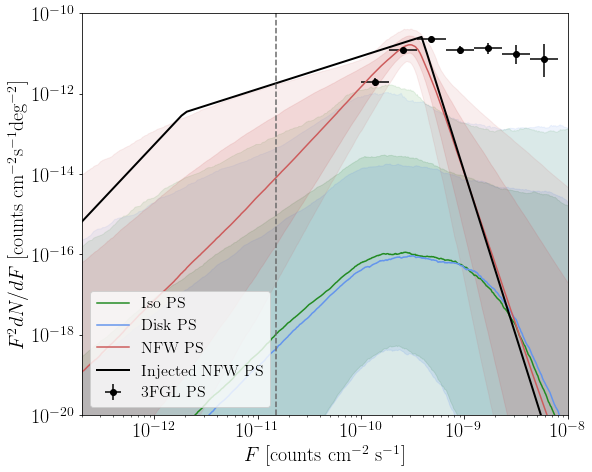

In [51]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/F2dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_50_50/F2dNdF'+GCE_tags[iGCE]+'.pdf')


In [52]:
# an.make_triangle()

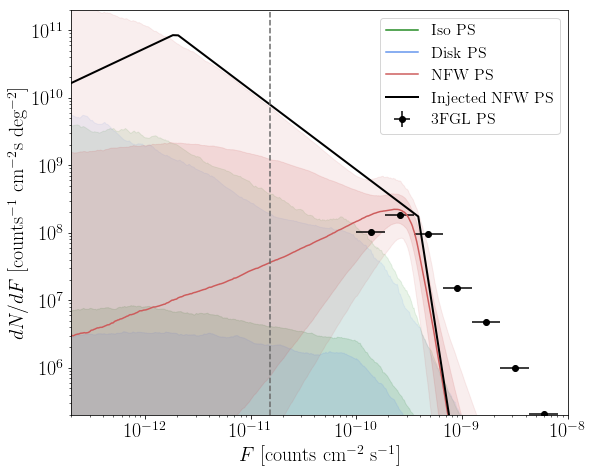

In [53]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_50_50/dNdF'+GCE_tags[iGCE]+'.pdf')


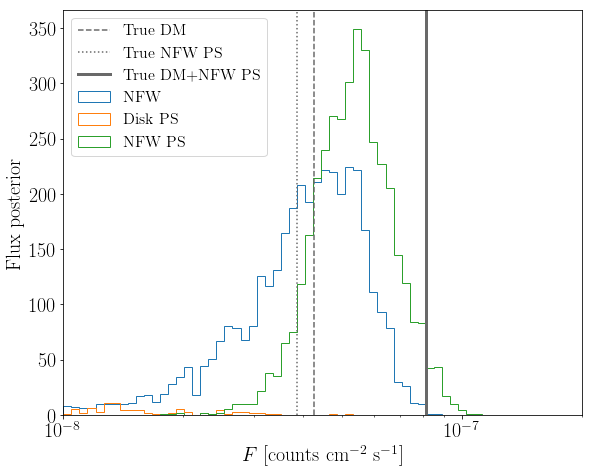

In [54]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',ls='--',label='True DM')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean+np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',label='True DM+NFW PS',linewidth=3)

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/fluxes'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_50_50/fluxes'+GCE_tags[iGCE]+'.pdf')


### PS + DM (100% GCE flux each)

In [178]:
iGCE = 1
psf_king = 1

In [179]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [180]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [181]:
data = np.load(sims_dir+"PS_below1ph_smoothDM_40GeV_100_100_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_100_GCE_flux_below1ph.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_100_GCE_flux_below1ph.npz")['counts_map']

In [182]:
mchi = 40
particle = pa.Particle(channel='b', m_chi = mchi * GeV)    

cross_section = 1.3e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [183]:
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_below1phPS_DM_100_100"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [184]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [186]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_below1phPS_DM_100_100_with_GCE_ps/.txt


In [187]:
an = dnds_analysis.Analysis(n)

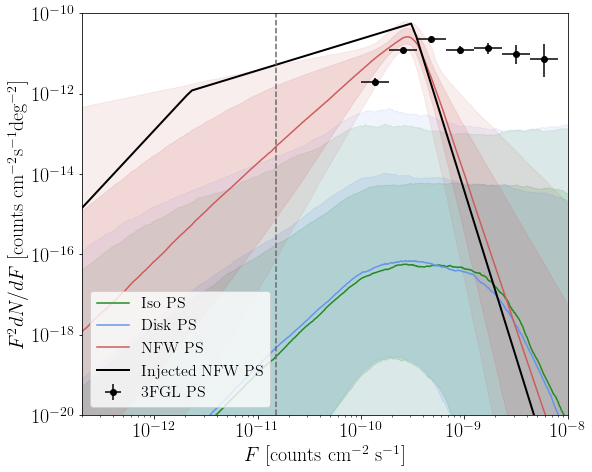

In [188]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_100_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')


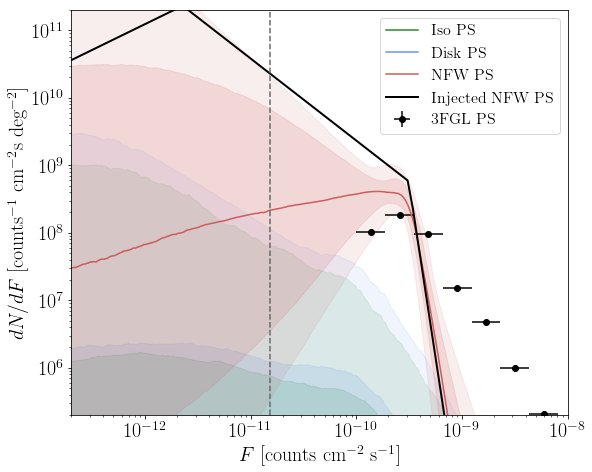

In [189]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_100_100/dNdF'+GCE_tags[iGCE]+'.pdf')


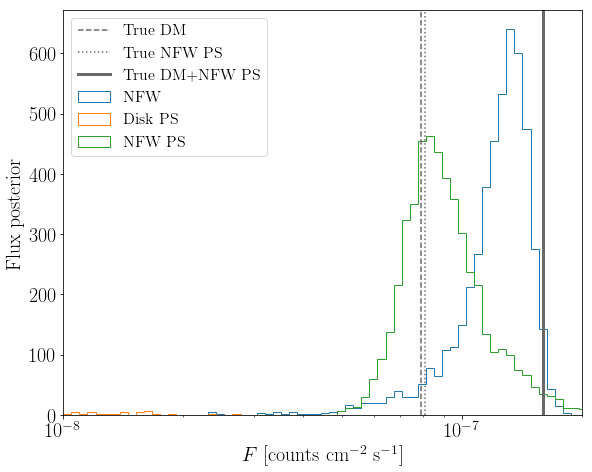

In [190]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',ls='--',label='True DM')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean+np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',label='True DM+NFW PS',linewidth=3)

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_DM_100_100/fluxes'+GCE_tags[iGCE]+'.pdf')


### PS only

In [68]:
iGCE = 1
psf_king = 1

In [69]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [70]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [71]:
data = np.load(sims_dir+"PS_below1ph_100_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_100_GCE_flux_below1ph.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_100_GCE_flux_below1ph.npz")['counts_map']

In [72]:
# n = nptfit.NPTF(work_dir="../",tag="king/widepriors/scan_below1phPS_100"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_below1phPS_100"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [73]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [74]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_below1phPS_100_with_GCE_ps/.txt


In [75]:
an = dnds_analysis.Analysis(n)

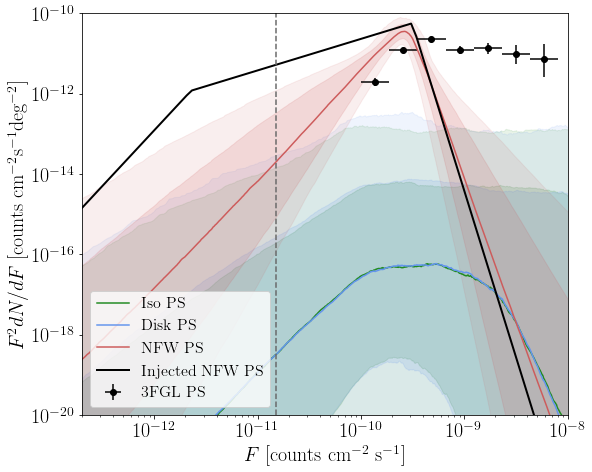

In [76]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/PS_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')


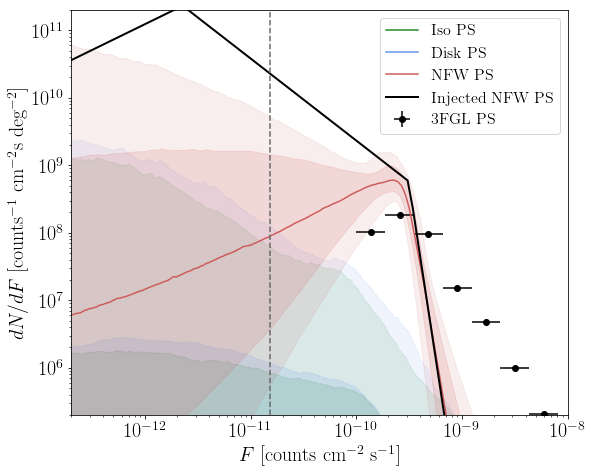

In [77]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/PS_100/dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_100/dNdF'+GCE_tags[iGCE]+'.pdf')


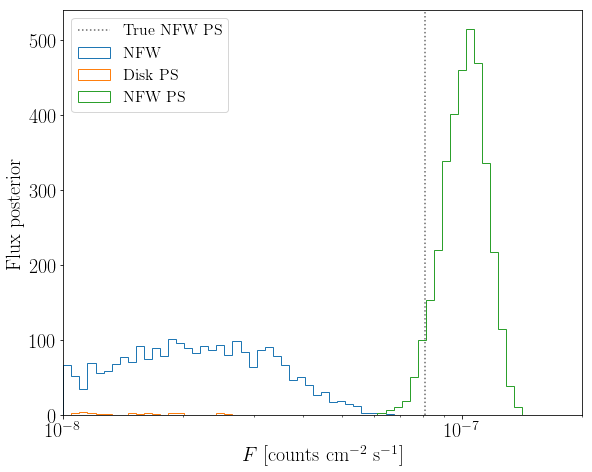

In [78]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_below1ph/PS_100/fluxes'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_below1ph/PS_100/fluxes'+GCE_tags[iGCE]+'.pdf')


## 1-break source-count

### PS + DM (50% GCE flux each)

In [116]:
iGCE = 1
psf_king = 1

In [117]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [118]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [119]:
data = np.load(sims_dir+"PS_1bk_smoothDM_40GeV_50_50_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_1bk_50_GCE_flux.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_1bk_50_GCE_flux.npz")['counts_map']

In [120]:
mchi = 40
particle = pa.Particle(channel='b', m_chi = mchi * GeV)    

cross_section = 0.7e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [121]:
# n = nptfit.NPTF(work_dir="../",tag="king/widepriors/scan_PS_1bk_DM_50_50"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_PS_1bk_DM_50_50"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [122]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [123]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_PS_1bk_DM_50_50_with_GCE_ps/.txt


In [124]:
an = dnds_analysis.Analysis(n)

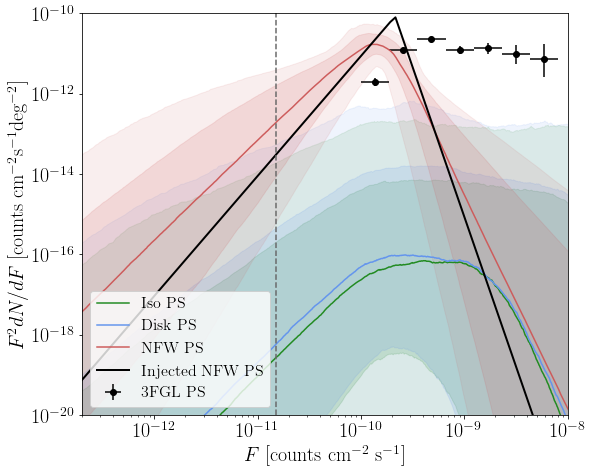

In [125]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_50_50/F2dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_50_50/F2dNdF'+GCE_tags[iGCE]+'.pdf')


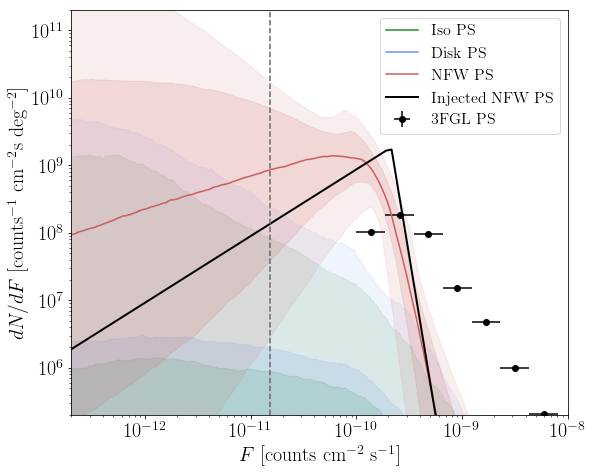

In [126]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_50_50/dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_50_50/dNdF'+GCE_tags[iGCE]+'.pdf')


In [127]:
# an.make_triangle()

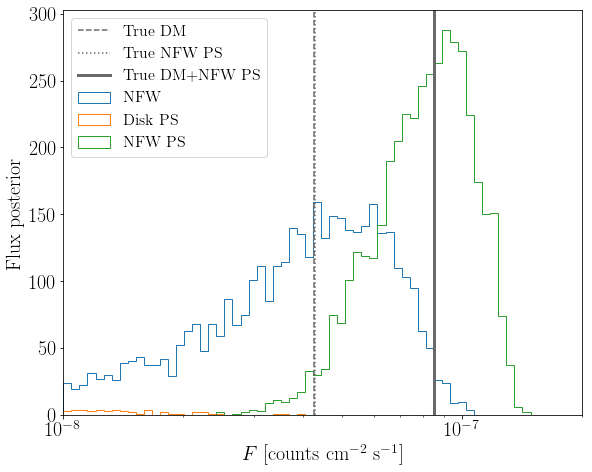

In [128]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',ls='--',label='True DM')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean+np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',label='True DM+NFW PS',linewidth=3)

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_50_50/fluxes'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_50_50/fluxes'+GCE_tags[iGCE]+'.pdf')


### PS + DM (100% GCE flux each)

In [142]:
iGCE = 1
psf_king = 1

In [143]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [144]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [145]:
data = np.load(sims_dir+"PS_1bk_smoothDM_40GeV_100_100_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_1bk_100_GCE_flux.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_1bk_100_GCE_flux.npz")['counts_map']

In [146]:
mchi = 40
particle = pa.Particle(channel='b', m_chi = mchi * GeV)    

cross_section = 1.3e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [147]:
# n = nptfit.NPTF(work_dir="../",tag="king/widepriors/scan_PS_1bk_DM_100_100"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_PS_1bk_DM_100_100"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [148]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [149]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_PS_1bk_DM_100_100_with_GCE_ps/.txt


In [150]:
an = dnds_analysis.Analysis(n)

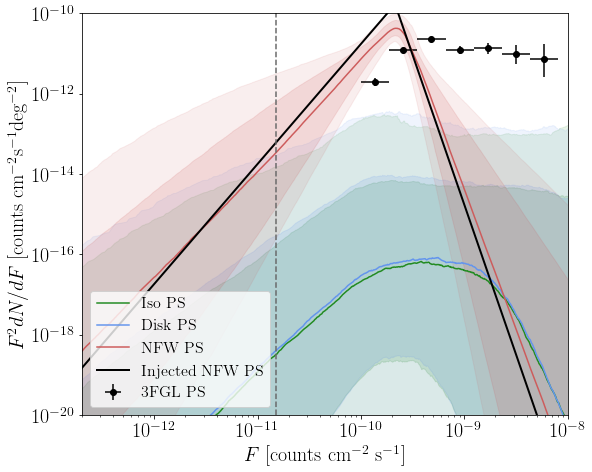

In [151]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_100_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_100_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')


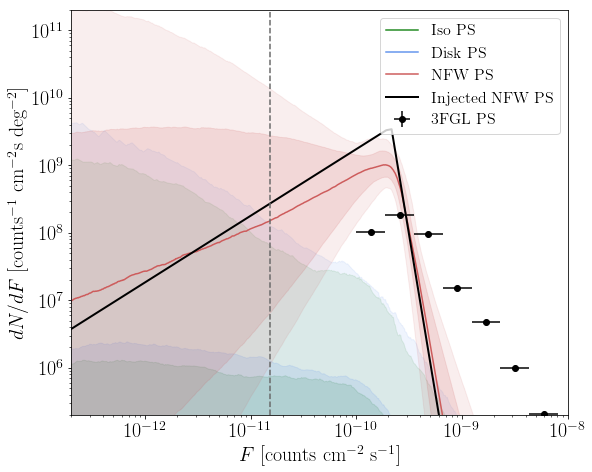

In [152]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_100_100/dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_100_100/dNdF'+GCE_tags[iGCE]+'.pdf')


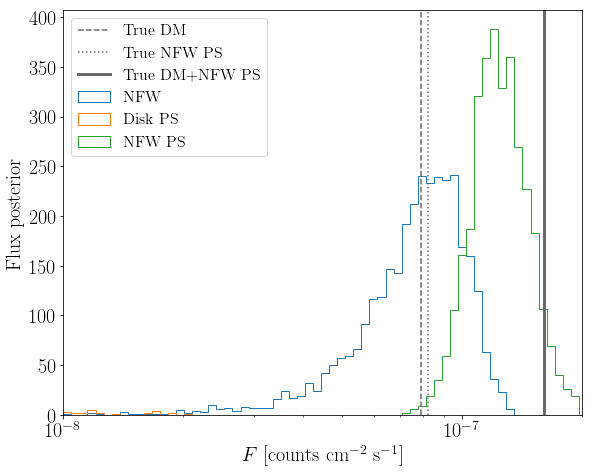

In [153]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',ls='--',label='True DM')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean+np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',label='True DM+NFW PS',linewidth=3)

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_DM_100_100/fluxes'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_DM_100_100/fluxes'+GCE_tags[iGCE]+'.pdf')


### PS only

In [167]:
iGCE = 1
psf_king = 1

In [168]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [169]:
rescale = fermi_exposure/np.mean(fermi_exposure)
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [170]:
data = np.load(sims_dir+"PS_1bk_100_0.npy").astype('int32')
sim_SCD = np.load("../data/kingPSF_NFW_PS_1bk_100_GCE_flux.npz")['SCD_params']
sim_map = np.load("../data/kingPSF_NFW_PS_1bk_100_GCE_flux.npz")['counts_map']

In [171]:
# n = nptfit.NPTF(work_dir="../",tag="king/widepriors/scan_PS_1bk_100"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/mask_0p8/scan_PS_1bk_100"+GCE_tags[iGCE])
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [172]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                      [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [173]:
n.load_scan()

  analysing data from ../chains/king/mask_0p8/scan_PS_1bk_100_with_GCE_ps/.txt


In [174]:
an = dnds_analysis.Analysis(n)

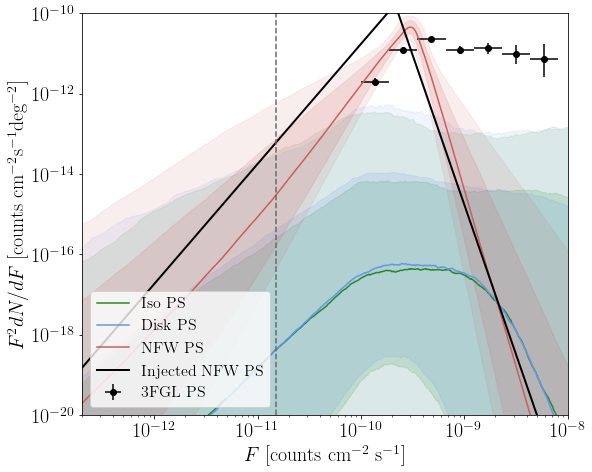

In [175]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_100/F2dNdF'+GCE_tags[iGCE]+'.pdf')


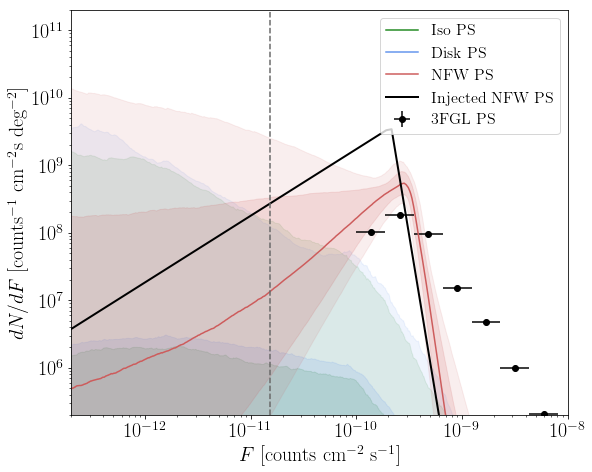

In [176]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
plt.plot(f_ary0,rf*np.array([dNdF_1break(*sim_SCD[0:3],sim_SCD[3]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_100/dNdF'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_100/dNdF'+GCE_tags[iGCE]+'.pdf')


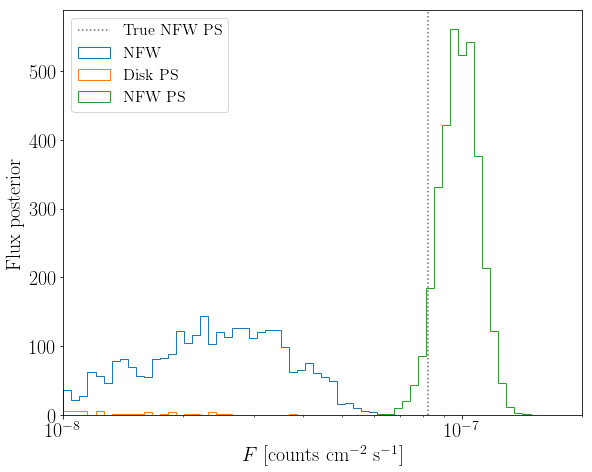

In [177]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/widepriors/NFWPS_1bk/PS_100/fluxes'+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/mask_0p8deg/NFWPS_1bk/PS_100/fluxes'+GCE_tags[iGCE]+'.pdf')


In [166]:
# an.make_triangle()